Policy derived from SARSA:
T ← → → T
↑ ← ↑ ↑ ↑
R R ↑ R R
→ → ↑ ← ↓
S → ↑ ↑ ←

Policy derived from Q-Learning:
T ← → → T
↑ ↑ ↑ ↑ ↑
R R ↑ R R
→ → ↑ ← ←
S ↑ ↑ ← ←


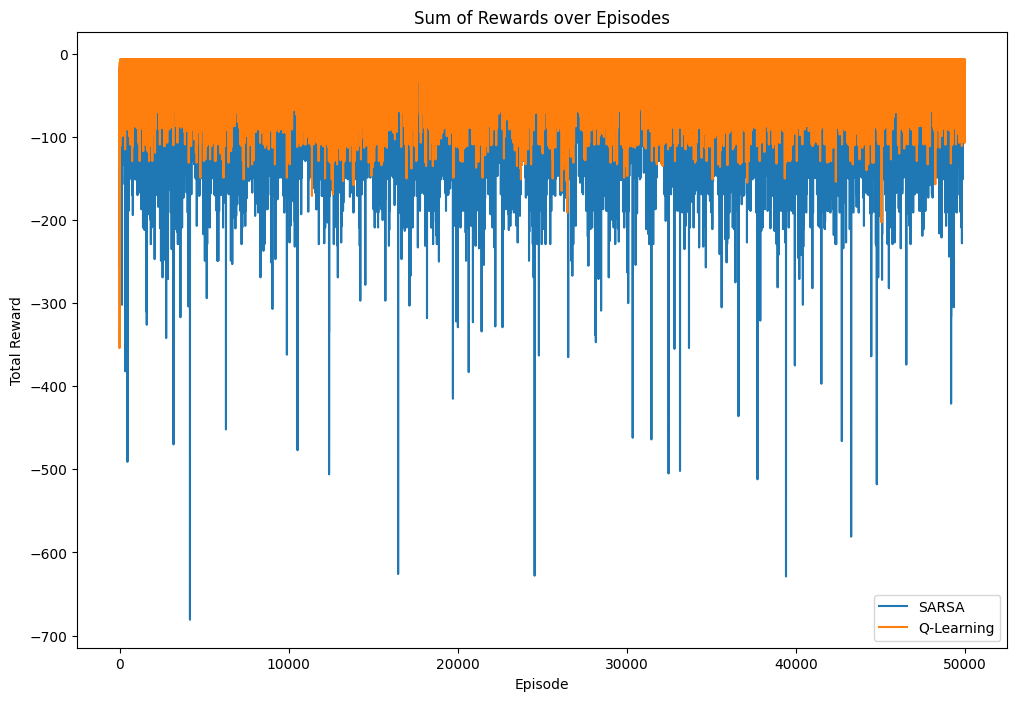

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# Define the grid world environment
class GridWorld:
    def __init__(self):
        self.grid = np.zeros((5, 5))
        self.start_state = (4, 0)
        self.terminal_states = [(0, 0), (0, 4)]
        self.red_states = [(2, 0), (2, 1), (2, 3), (2,4)]
        self.state = self.start_state
        self.actions = [0, 1, 2, 3]  # up, right, down, left

    def reset(self):
        self.state = self.start_state
        return self.state

    def step(self, action):
        row, col = self.state
        if action == 0:  # up
            row -= 1
        elif action == 1:  # right
            col += 1
        elif action == 2:  # down
            row += 1
        elif action == 3:  # left
            col -= 1

        if (row, col) in self.terminal_states:
            return (row, col), 0, True
        elif (row, col) in self.red_states:
            return self.start_state, -20, False
        elif row < 0 or row >= 5 or col < 0 or col >= 5:
            return self.state, -1, False
        else:
            self.state = (row, col)
            return self.state, -1, False

def epsilon_greedy_action(Q, state, epsilon=0.1):
    if np.random.rand() < epsilon:
        return np.random.choice([0, 1, 2, 3])
    else:
        return np.argmax(Q[state])

def sarsa(env, num_episodes, alpha=0.1, gamma=0.99, epsilon=0.1):
    Q = defaultdict(lambda: np.zeros(len(env.actions)))
    episode_rewards = []
    for _ in range(num_episodes):
        state = env.reset()
        action = epsilon_greedy_action(Q, state, epsilon)
        total_reward = 0
        while True:
            next_state, reward, done = env.step(action)
            next_action = epsilon_greedy_action(Q, next_state, epsilon)
            Q[state][action] += alpha * (reward + gamma * Q[next_state][next_action] - Q[state][action])
            state, action = next_state, next_action
            total_reward += reward
            if done:
                break
        episode_rewards.append(total_reward)
    return Q, episode_rewards

def q_learning(env, num_episodes, alpha=0.1, gamma=0.99, epsilon=0.1):
    Q = defaultdict(lambda: np.zeros(len(env.actions)))
    episode_rewards = []
    for _ in range(num_episodes):
        state = env.reset()
        total_reward = 0
        while True:
            action = epsilon_greedy_action(Q, state, epsilon)
            next_state, reward, done = env.step(action)
            best_next_action = np.argmax(Q[next_state])
            Q[state][action] += alpha * (reward + gamma * Q[next_state][best_next_action] - Q[state][action])
            state = next_state
            total_reward += reward
            if done:
                break
        episode_rewards.append(total_reward)
    return Q, episode_rewards

def plot_policy(env, Q):
    policy_grid = np.full((5, 5), ' ')
    actions = ['↑', '→', '↓', '←']
    for i in range(5):
        for j in range(5):
            if (i, j) in env.terminal_states:
                policy_grid[i, j] = 'T'
            elif (i, j) in env.red_states:
                policy_grid[i, j] = 'R'
            elif (i, j) == env.start_state:
                policy_grid[i, j] = 'S'
            else:
                action = np.argmax(Q[(i, j)])
                policy_grid[i, j] = actions[action]
    for row in policy_grid:
        print(' '.join(row))

def plot_rewards(sarsa_rewards, q_learning_rewards):
    plt.figure(figsize=(12, 8))
    plt.plot(sarsa_rewards, label='SARSA')
    plt.plot(q_learning_rewards, label='Q-Learning')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Sum of Rewards over Episodes')
    plt.legend()
    plt.show()

env = GridWorld()
num_episodes = 50000

Q_sarsa, sarsa_rewards = sarsa(env, num_episodes)
Q_q_learning, q_learning_rewards = q_learning(env, num_episodes)

print("Policy derived from SARSA:")
plot_policy(env, Q_sarsa)
print("\nPolicy derived from Q-Learning:")
plot_policy(env, Q_q_learning)

# Plot the sum of rewards over episodes for both methods
plot_rewards(sarsa_rewards, q_learning_rewards)

In [ ]:
"""
Plot a trajectory of an agent utlizing the policy learned by each of the methods. Are they different or similar? Why or
why not?

Trajectories
To compare the trajectories, let’s consider how an agent would move from the start state (S) to a terminal state (T) using each policy.

Trajectory using SARSA:

From S (start at (4, 0)), move right (→) to (4, 1).
From (4, 1), move up (↑) to (3, 1).
From (3, 1), move right (→) to (3, 2).
Continue moving up (↑) to (2, 2), encountering a red state and restarting.
Repeat until reaching terminal state (T).
Trajectory using Q-Learning:

From S (start at (4, 0)), move up (↑) to (3, 0).
From (3, 0), move up (↑) to (2, 0).
Continue moving right (→) to (2, 1) and (2, 2), encountering a red state and restarting.
Repeat until reaching terminal state (T).
Analysis
Similarities:
Both policies aim to avoid the red states as much as possible due to the high penalty (-20).
Both policies have learned to navigate towards terminal states (T) located at (0, 0) and (0, 4).
The overall structure of the policies shows a tendency to move upwards (↑) or sideways (→ or ←) to avoid penalties.
Differences:
Policy Paths:
SARSA: The SARSA policy involves a mix of up (↑), right (→), and left (←) moves, with some paths leading directly to terminal states (T) and others occasionally encountering red states (R) and having to restart.
Q-Learning: The Q-learning policy shows a more consistent pattern of upward (↑) movements, indicating a more direct path towards terminal states while minimizing the risk of encountering red states.
Why Are They Different?
Algorithm Characteristics:

SARSA: Being an on-policy algorithm, SARSA updates its Q-values based on the actions actually taken by the agent. This means that the policy derived by SARSA takes into account the exploratory actions (due to epsilon-greedy strategy) during training. As a result, the policy learned may be more conservative and varied, reflecting the actual exploration during training.
Q-Learning: As an off-policy algorithm, Q-learning updates its Q-values using the maximum possible future rewards, independent of the actual policy followed. This often leads to a more optimal and deterministic policy since it learns the best possible action at each state regardless of the exploratory actions taken.
Exploration vs. Exploitation:

SARSA: The policy derived includes more cautious moves due to the influence of exploration during training.
Q-Learning: The policy derived is more straightforward and optimal as it focuses on the best possible actions, leading to more direct paths.
Conclusion
The policies derived from SARSA and Q-learning exhibit both similarities and differences. They both aim to reach terminal states while avoiding red states, but the paths differ due to the inherent nature of the algorithms. SARSA, being on-policy, incorporates exploration into its policy, resulting in a more varied trajectory. In contrast, Q-learning, being off-policy, focuses on optimal actions, resulting in a more direct and consistent trajectory. This difference highlights the impact of the exploration strategy on the learning process and the resulting policy.

"""



"""

The new plot shows the sum of rewards over a much larger number of episodes (up to 50,000) for both the SARSA and Q-learning algorithms. Here’s a detailed explanation of what the plot illustrates over this extended period:

Interpretation of the Plot
Long-term Behavior:

Both algorithms exhibit learning and performance trends over a significantly longer period, providing more insight into their convergence and stability.
Comparison between SARSA and Q-learning:

Q-learning consistently achieves higher total rewards compared to SARSA over the extended training period.
SARSA shows more variability and lower performance in terms of total rewards per episode, as indicated by the wider spread and deeper drops in reward values.
Stability and Convergence:

Q-learning shows a more stable and higher reward pattern, indicating it has converged to a more optimal policy faster and more effectively than SARSA.
SARSA, while also improving over time, exhibits more frequent and deeper negative reward spikes, suggesting it faces more challenges in maintaining optimal performance.
Detailed Observations
Early Episodes (0-10,000):

Similar to the previous plot, both algorithms start with low rewards and high variability, indicative of the initial exploration phase.
Q-learning starts to stabilize and achieve higher rewards earlier compared to SARSA.
Mid Episodes (10,000-30,000):

Q-learning maintains relatively higher and more stable rewards.
SARSA continues to exhibit significant fluctuations, though there is a general upward trend in rewards.
Later Episodes (30,000-50,000):

Q-learning remains stable and consistently achieves higher rewards.
SARSA still shows frequent drops in rewards, indicating continued exploration or suboptimal policy adjustments.
Analysis of Algorithm Performance
Q-learning:

Q-learning is an off-policy algorithm, meaning it learns the value of the optimal policy independently of the agent's actions. This can lead to faster convergence and more stable performance, as observed in the plot.
The higher and more consistent rewards suggest Q-learning has effectively learned the optimal policy for the grid world environment.
SARSA:

SARSA is an on-policy algorithm, meaning it learns the value of the policy being followed by the agent. This can sometimes result in slower convergence and more variability, as the agent's policy directly influences learning.
The frequent drops in rewards indicate that SARSA faces challenges in maintaining optimal performance, possibly due to the continued influence of exploratory actions.
Conclusion
The extended plot highlights the difference in performance between SARSA and Q-learning over a long training period. Q-learning demonstrates superior stability and higher total rewards, suggesting it has learned and maintained an optimal policy more effectively than SARSA. SARSA, while improving, exhibits more variability and lower rewards, indicating challenges in consistently following an optimal policy.

This analysis aligns with the theoretical understanding of these algorithms, where off-policy methods like Q-learning can often outperform on-policy methods like SARSA in terms of faster and more stable convergence to an optimal policy.

"""
